In [1]:
import os
import json
import pandas as pd
import numpy as np
from pandas.io.json import json_normalize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
import quandl

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

def news_df(news_type, year):
    df_lst=[]
    folders = ['economy', 'finance', 'stocks', 'stocks market']
    for month in range(1, 13):
        if month<10:
            month = str(0)+str(month)
        for folder in folders:
            path = os.path.join('Data', news_type, year, str(month), folder, 'index.json')
            with open(path, 'r') as f:
                data = json.load(f)

            news_lst=[]
            news_dict = dict.fromkeys(['id','category', 'section', 'date', 'news_header'])
            ttl_shape = np.array(data)
            
            if news_type =='NYT':
                for i in range(ttl_shape.shape[0]-1):
                    for a in ttl_shape[i][:]:
                        news_dict['id'] = a['_id']
                        news_dict['date'] = a['pub_date']
                        news_dict['news_header'] = a['headline']['main']
                        try:
                            news_dict['category'] = a['news_desk']
                            news_dict['section'] = a['section_name']
                        except:
                            pass
                        news_lst.append(news_dict.copy())
            else:
                 for i in range(ttl_shape.shape[0]):
                    for a in ttl_shape[i][:]:
                        news_dict['id'] = a['id']
                        news_dict['date'] = a['fields']['firstPublicationDate']
                        news_dict['news_header'] = a['fields']['headline']
                        try:
                            news_dict['category'] = a['sectionId']
                            news_dict['section'] = a['sectionName']
                        except:
                            pass
                        news_lst.append(news_dict.copy())
                        
            file = 'df'+str(month)+folder
            file = pd.DataFrame.from_dict(json_normalize(news_lst), orient='columns')
            df_lst.append(file)
        news_df = pd.concat(df_lst, ignore_index=True)
    return news_df

def preprocess(news, start_date, end_date):
    news['date'] = pd.to_datetime(news['date'])
    news['month'] = news['date'].apply(lambda x: x.month)
    news['date_yr_mnth'] = news['date'].map(lambda x: x.strftime('%Y-%m'))
    news['date'] = news['date'].map(lambda x: x.strftime('%Y-%m-%d'))
    
    news_df = news.loc[(news['date_yr_mnth'] >= start_date) & (news['date_yr_mnth'] <= end_date)]
    sid = SentimentIntensityAnalyzer()
    news_df['sentiment']=news_df['news_header'].apply(lambda x:sid.polarity_scores(x)['compound'])
    
    return news_df
    
def stocks(start_date, end_date):
# use quandl to acquire nasdaq composite
    ndq = quandl.get("NASDAQOMX/COMP-NASDAQ",
                        start_date = start_date, 
                        end_date = end_date)
    #               start_date='2016-01-01', 
    #               end_date='2016-12-31')
    ndq_df = ndq.reset_index()
    return ndq_df

def plot(NYT_df, Guardian_df, ndq_df):
    NYT_ttl = NYT_df.groupby(['date'])['id'].count().reset_index()
    NYT_ttl['date'] = pd.to_datetime(NYT_ttl['date'])
    NYT_result = pd.merge(ndq_df, NYT_ttl, left_on=['Trade Date'], right_on = ['date'], how='left')
    
    Guardian_ttl = Guardian_df.groupby(['date'])['id'].count().reset_index()
    Guardian_ttl['date'] = pd.to_datetime(Guardian_ttl['date'])
    Guardian_result = pd.merge(ndq_df, Guardian_ttl, left_on=['Trade Date'], right_on = ['date'], how='left')
    Guardian_result['id'].fillna(0,inplace=True)
    
    x = NYT_result['date']

    plt.figure(figsize=(16,7))
    plt.subplot(1,1,1)
    plt.plot(x, ndq_df['Index Value']/30, label='NASDAQ Index')
    # plt.plot(x, ttl_news_df['news_sum'], label='Total news')
    plt.plot(x, ndq_df['Total Market Value']/ (5*1e10), label='NASDAQ Total Market Value')
    plt.plot(x, NYT_result['id'], label='New York Times')
    plt.plot(x, Guardian_result['id'], label='The Guardian')
    plt.xlabel('Date')
    plt.legend(bbox_to_anchor=(1, 1), fontsize='large')
    
    year = NYT_result.iloc[0]['date'].strftime('%Y')
    plt.ylabel("Comparing NASDAQ Market with News")
    plt.title("%s news relationship with NASDAQ Index"% (year))
    plt.grid(True)

/Users/denise/anaconda3/lib/python3.6/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


/Users/denise/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


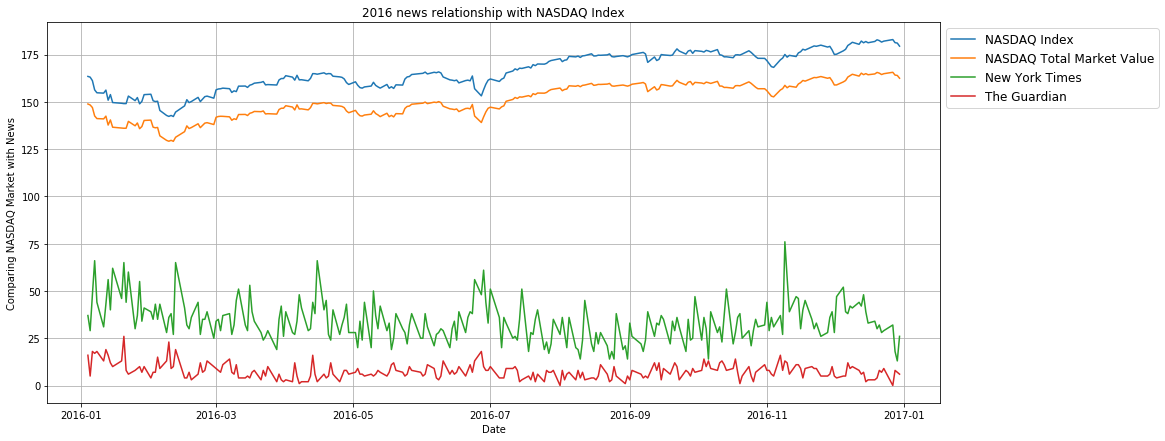

In [2]:
NYT_news_2016 = news_df('NYT', '2016')
NYT_news_df_2016 = preprocess(NYT_news_2016, '2016-01', '2016-12')
Guard_news_2016 = news_df('The Guardian', '2016')
Guard_news_df_2016 = preprocess(Guard_news_2016, '2016-01', '2016-12')
stocks_df = stocks('2016-01-01', '2016-12-31')
plot(NYT_news_df_2016, Guard_news_df_2016, stocks_df)

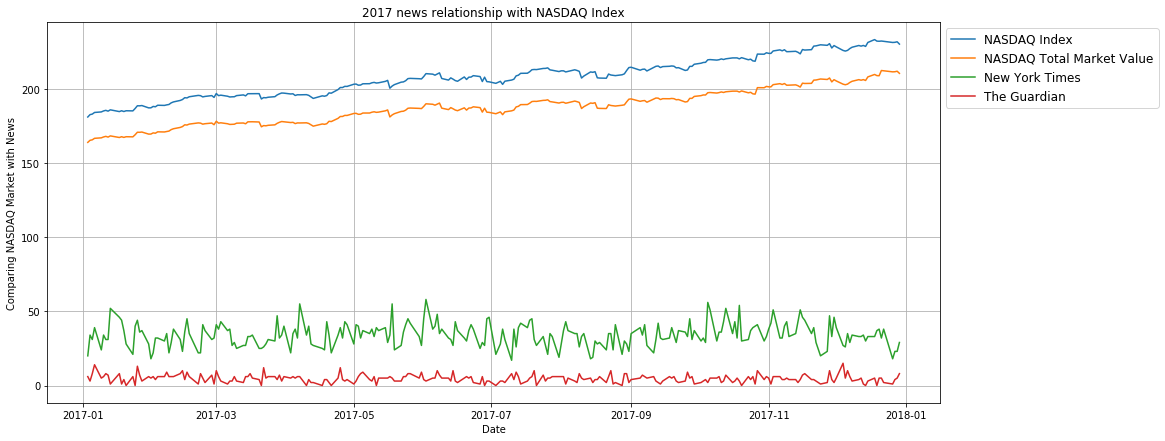

In [3]:
NYT_news_2017 = news_df('NYT', '2017')
NYT_news_df_2017 = preprocess(NYT_news_2017, '2017-01', '2017-12')
Guard_news_2017 = news_df('The Guardian', '2017')
Guard_news_df_2017 = preprocess(Guard_news_2017, '2017-01', '2017-12')
stocks_df = stocks('2017-01-01', '2017-12-31')
plot(NYT_news_df_2017, Guard_news_df_2017, stocks_df)

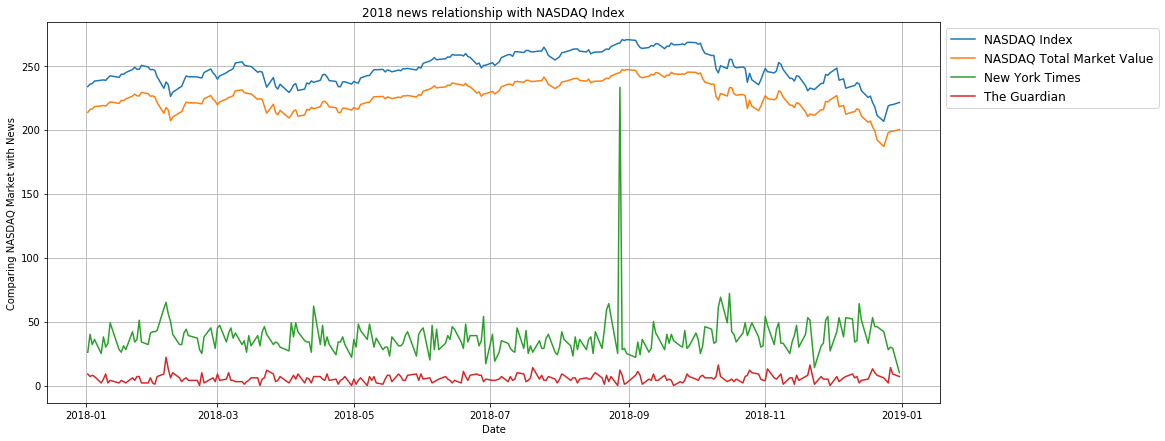

In [4]:
NYT_news_2018 = news_df('NYT', '2018')
NYT_news_df_2018 = preprocess(NYT_news_2018, '2018-01', '2018-12')
Guard_news_2018 = news_df('The Guardian', '2018')
Guard_news_df_2018 = preprocess(Guard_news_2018, '2018-01', '2018-12')
stocks_df = stocks('2018-01-01', '2018-12-31')
plot(NYT_news_df_2018, Guard_news_df_2018, stocks_df)

In [5]:
import re

def preprocess_cate(category_lst):
    # lowercase the news header
    lower_cate = [x.lower() for x in category_lst]
    # remove punctuation
    no_punct_cate = [re.sub(r'[^\w\s]', '', x) for x in lower_cate]
    token = [(x.split(), y) for (x, y) in zip(no_punct_cate, category_lst)]
    
    return token

def jaccard(r, s, threshold):
    if (min(len(r), len(s)) ==0) or (min(len(r), len(s)) / max(len(r), len(s)) < threshold):
        return 0

    intersect = set(r).intersection(s)
    union = len(r) + len(s) - len(intersect)

    if union != 0:
        return 1.0*len(intersect) / union
    else:
        return 0

# Find sim data recursively
def search_sim(iset, item, l):
    if len(l) == 0:
        return iset, l
    for i in l:
        if jaccard(item[0], i[0], 0.5) > 0:
            iset.append(i)
            l.remove(i)
            search_sim(iset, i, l)
    return iset, l


In [6]:
ttl_news_df = [NYT_news_2016, NYT_news_2017, NYT_news_2018, Guard_news_2016, Guard_news_2017, Guard_news_2018]
result = pd.concat(ttl_news_df, sort=False)
category_lst = result['category'].dropna().unique().tolist()
cate_lst = preprocess_cate(category_lst)
# print(cate_lst)
groups = []
for instance in cate_lst:
    sim_lst = []
    sim_lst, cate = search_sim(sim_lst, instance, cate_lst[1:])
    cate_lst = cate
    if len(sim_lst) > 0:
        sim_lst.append(instance)
        groups.append((sim_lst))

mapping = dict()
# print(groups)
for group in groups:
    print(group)
    text = [v for k,v in group]
    target = max(text, key=len)
#     print(target)
    for i in text:
        mapping[i]=target
        
result['cate_matching'] = result['category'].replace(mapping)
# result['cate_matching']

[(['business', 'day'], 'Business Day'), (['business', 'day', 'international', 'business'], 'Business Day / International Business'), (['business', 'day', 'dealbook'], 'Business Day / DealBook'), (['business', 'day', 'economy'], 'Business Day / Economy'), (['business'], 'business'), (['business'], 'Business')]
[(['us', 'politics'], 'U.S. / Politics'), (['us'], 'U.S.'), (['us', 'elections'], 'U.S. / Elections'), (['us', 'election', '2016'], 'U.S. / Election 2016'), (['politics'], 'Politics')]
[(['t', 'magazine'], 'T Magazine'), (['magazine'], 'Magazine')]
[(['the', 'upshot'], 'The Upshot'), (['the', 'learning', 'network'], 'The Learning Network'), (['upshot'], 'Upshot')]
[(['world', 'africa'], 'World / Africa'), (['world', 'asia', 'pacific'], 'World / Asia Pacific'), (['world', 'europe'], 'World / Europe'), (['world'], 'World'), (['world', 'canada'], 'World / Canada'), (['world', 'middle', 'east'], 'World / Middle East'), (['world', 'americas'], 'World / Americas')]
[(['new', 'york'], 'N

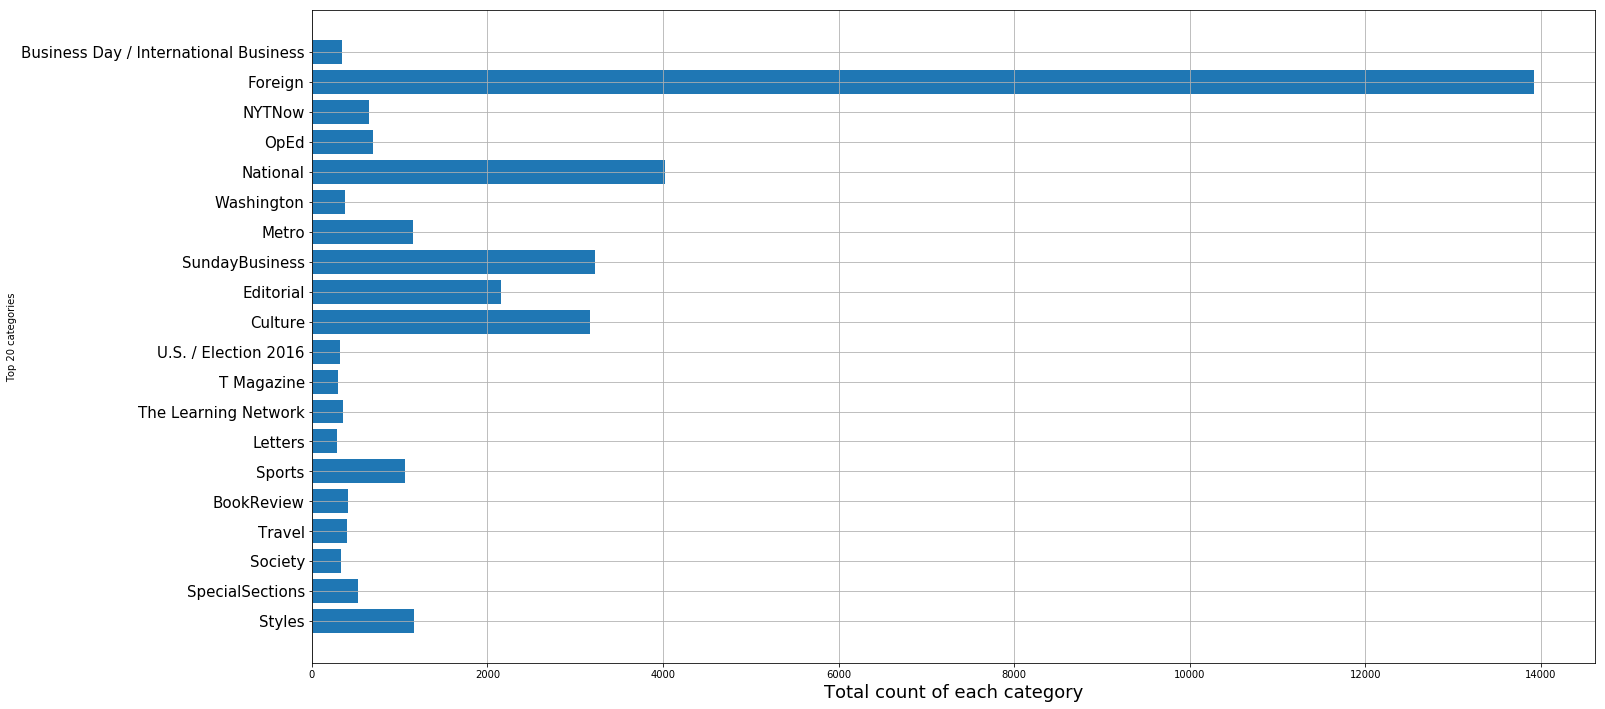

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline


df_result = result.loc[(result['cate_matching'].notnull()) & (result['cate_matching'] != 'None') & (result['cate_matching'] != '')]
df_result1 = df_result.groupby('cate_matching').size().reset_index(name='counts')
# top 20 categories
top20_cate = df_result1.nlargest(20, 'counts')
top20_cate_index = top20_cate['cate_matching'].tolist()
fig, ax = plt.subplots(figsize=(23, 12))
ax.barh(top20_cate_index, top20_cate['counts'], align='center')
ax.invert_yaxis()
ax.set_xlabel('Total count of each category', fontsize=18)
ax.set_ylabel('Top 20 categories')
ax.set_yticklabels(top20_cate_index, fontsize=15)
ax.grid()

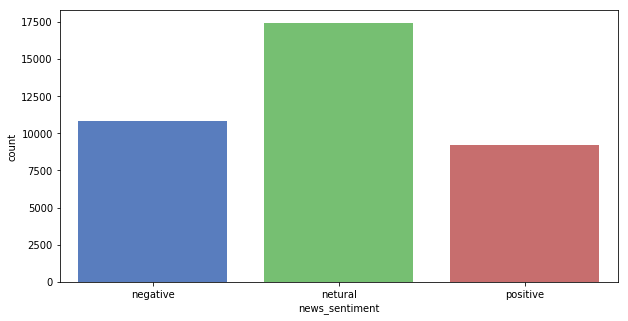

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

def senti(col):
    if col==0:
        return 'netural'
    elif col>0:
        return 'positive'
    else:
        return 'negative'
# total distribution of news with sentiment
pro_news = [NYT_news_df_2016, NYT_news_df_2017, NYT_news_df_2018, Guard_news_df_2016, Guard_news_df_2017, Guard_news_df_2018]
ttl_pro_news = pd.concat(pro_news, sort=False)
ttl_pro_news['senti_token'] = ttl_pro_news['sentiment'].apply(senti)
ttl_pro_news_df = ttl_pro_news.groupby('senti_token').size().reset_index(name='counts')

plt.figure(figsize=(10,5))
sns.set_palette("muted")
sns.barplot(x="senti_token", y="counts", data=ttl_pro_news_df)
plt.xlabel('news_sentiment')
plt.ylabel('count')
plt.show()

In [13]:
def word_cloud(text, image, stopwords, title):
    mask = np.array(Image.open(image))
    
    # Create a word cloud image
    wc = WordCloud(background_color="white", max_words=3000, mask=mask,
                   stopwords=stopwords, height=300, width=300, random_state=1)

    # Generate a wordcloud
    wc.generate(text)

#     # store to file
#     wc.to_file("img/wine.png")

    # show
    plt.figure(figsize=(15,7))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.figtext(.5,.9, title, fontsize=20, ha='center')
#     plt.title(title)
    plt.show()

/Users/denise/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/denise/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


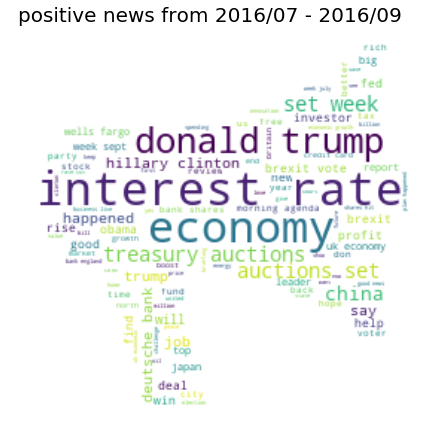

In [14]:
from PIL import Image
from wordcloud import WordCloud, STOPWORDS

# see which words appear more frequently for positive news from 2016/07 - 2016/09
NYT_news_2016 = news_df('NYT', '2016')
NYT_news_df_2016 = preprocess(NYT_news_2016, '2016-01', '2016-12')
Guard_news_2016 = news_df('The Guardian', '2016')
Guard_news_df_2016 = preprocess(Guard_news_2016, '2016-01', '2016-12')

NYT2016_news = [NYT_news_df_2016, Guard_news_df_2016]
ttl__NYT2016_news = pd.concat(NYT2016_news, sort=False)
ttl__NYT2016_news = ttl__NYT2016_news.loc[(ttl__NYT2016_news['date_yr_mnth'] >= '2016-07') & (ttl__NYT2016_news['date_yr_mnth'] <= '2016-09')]
ttl__NYT2016_news['senti_token'] = ttl__NYT2016_news['sentiment'].apply(senti)
ttl__NYT2016_news1 = ttl__NYT2016_news.loc[ttl__NYT2016_news['senti_token'] == 'positive']
# preprocess the news_header
ttl__NYT2016_news1['news_header'] = ttl__NYT2016_news1['news_header'].apply(lambda x:" ".join(x.lower() for x in x.split()))
text = ' '.join(item for item in ttl__NYT2016_news1['news_header'])

stopwords = set(STOPWORDS)
word_cloud(text, 'megaphone12.png',stopwords, 'positive news from 2016/07 - 2016/09')

/Users/denise/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/denise/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/denise/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

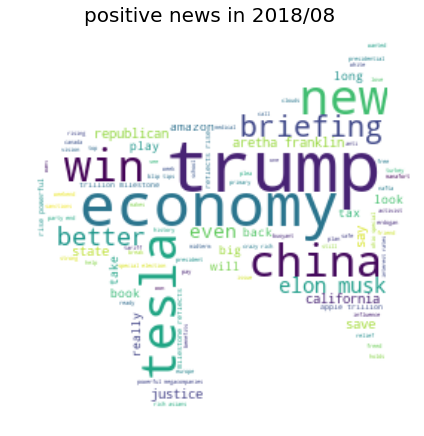

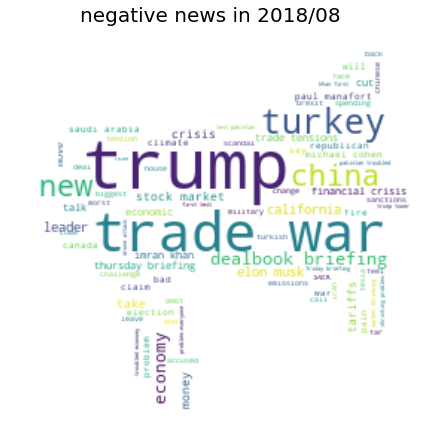

In [15]:
from PIL import Image
from wordcloud import WordCloud, STOPWORDS

# see which words appear more frequently for positive news on 2018/08
NYT_news_2018 = news_df('NYT', '2018')
NYT_news_df_2018 = preprocess(NYT_news_2018, '2018-01', '2018-12')


ttl__NYT2018_news = NYT_news_df_2018.loc[NYT_news_df_2018['date_yr_mnth'] == '2018-08']
ttl__NYT2018_news['senti_token'] = ttl__NYT2018_news['sentiment'].apply(senti)
ttl__NYT2018_news1 = ttl__NYT2018_news.loc[ttl__NYT2018_news['senti_token'] == 'positive']
ttl__NYT2018_news2 = ttl__NYT2018_news.loc[ttl__NYT2018_news['senti_token'] == 'negative']
# # preprocess the news_header
ttl__NYT2018_news1['news_header'] = ttl__NYT2018_news1['news_header'].apply(lambda x:" ".join(x.lower() for x in x.split()))
text = ' '.join(item for item in ttl__NYT2018_news1['news_header'])
ttl__NYT2018_news2['news_header'] = ttl__NYT2018_news2['news_header'].apply(lambda x:" ".join(x.lower() for x in x.split()))
text1 = ' '.join(item for item in ttl__NYT2018_news2['news_header'])

stopwords = set(STOPWORDS)
word_cloud(text, 'megaphone12.png', stopwords, 'positive news in 2018/08')

word_cloud(text1, 'megaphone12.png', stopwords, 'negative news in 2018/08')

/Users/denise/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/denise/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


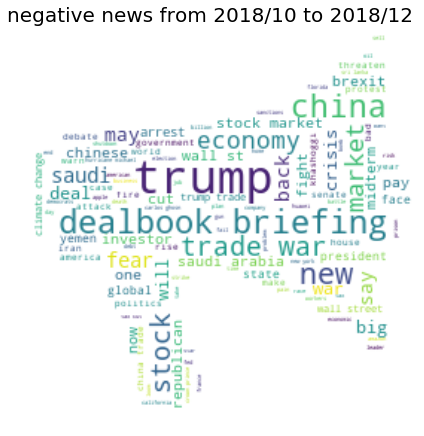

In [16]:
from PIL import Image
from wordcloud import WordCloud, STOPWORDS

# see which words appear more frequently for positive news on 2018/08
NYT_news_2018 = news_df('NYT', '2018')
NYT_news_df_2018 = preprocess(NYT_news_2018, '2018-01', '2018-12')


ttl__NYT2018_news = NYT_news_df_2018.loc[(NYT_news_df_2018['date_yr_mnth'] >= '2018-10') & (NYT_news_df_2018['date_yr_mnth'] <= '2018-12')]
ttl__NYT2018_news['senti_token'] = ttl__NYT2018_news['sentiment'].apply(senti)
ttl__NYT2018_news1 = ttl__NYT2018_news.loc[ttl__NYT2018_news['senti_token'] == 'negative']
# # preprocess the news_header
ttl__NYT2018_news1['news_header'] = ttl__NYT2018_news1['news_header'].apply(lambda x:" ".join(x.lower() for x in x.split()))
text = ' '.join(item for item in ttl__NYT2018_news1['news_header'])

stopwords = set(STOPWORDS)
word_cloud(text, 'megaphone12.png', stopwords, 'negative news from 2018/10 to 2018/12')